In [8]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import joblib
import pickle

import logging
from utils import *
from Lib.DataLoader import DataLoader

logging.basicConfig(level=logging.ERROR)

def load_split_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=True)
    train_lines, val_lines = dl.split_data_by_cls_num(lines, cls_col)
    train_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in train_lines]
    train_y = [int(l[cls_col]) for l in train_lines]
    val_X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in val_lines]
    val_y = [int(l[cls_col])for l in val_lines]
    val_id = [l[0:2] for l in val_lines]

    return train_X, train_y, val_X, val_y, val_id


def load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    dl = DataLoader()
    lines = dl.load_data_lines(file_path, num_fields=num_fields, separator=separator, skip_title=skip_title, shuffle=True)
    X = [[int(e) for e in l[start_feature_col:end_feature_col+1]] for l in lines]
    y = [int(l[cls_col]) for l in lines]
    ids = [l[0:2] for l in lines]

    return X, y, ids

def load_data_arr(file_path_arr, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col):
    X, y, ids = [], [], []
    for file_path in file_path_arr:
        X_, y_, ids_ = load_data(file_path, num_fields, separator, skip_title, cls_col, start_feature_col, end_feature_col)
        X.extend(X_)
        y.extend(y_)
        ids.extend(ids_)

    return X, y, ids


def write_pred_result(val_id, val_y, prediction, model_name):
    with open(r'data/%s.txt' % model_name, 'w') as f:
        for (id, dt), y, y_ in zip(val_id, val_y, prediction):
            f.write('%s,%s,%s,%s\n' % (id, dt, y, y_))

def run_test(scaler, model, X, y):
    X = scaler.transform(X)
    prediction = model.predict(X)
    matrix = metrics.confusion_matrix(y, prediction)
    accuracy = metrics.accuracy_score(y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

In [9]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

font = FontProperties(fname="SimHei.ttf", size=14)
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        print(cm)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("显示百分比：")
#         np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    else:
        cm_ = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
#         print('显示具体数字：')
#         print(cm_)
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # matplotlib版本问题，如果不加下面这行代码，则绘制的混淆矩阵上下只能显示一半，有的版本的matplotlib不需要下面的代码，分别试一下即可
    plt.ylim(len(classes) - 0.5, -0.5)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontproperties=font)
    plt.xlabel('Predicted label', fontproperties=font)
    plt.show()


In [10]:
tags = ["急性阑尾炎", "急性胰腺炎", "肠梗阻", "异位妊娠", "急性胆管炎", "急性胆囊炎", "上尿路结石", "卵巢囊肿破裂", "卵巢囊肿扭转", "消化道穿孔"]

def train_and_save(model, train_X, train_y, val_X, val_y, val_id, model_name):
    ss = StandardScaler()
    train_X = ss.fit_transform(train_X)
    val_X = ss.transform(val_X)
    
#     # 创建分类器
#     # model = svm.SVC()
#     model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
#                                     n_estimators=1200, learning_rate=0.05, subsample=0.95)

    # 用训练集做训练
    model.fit(train_X, train_y)
    # 用测试集做预测
    prediction=model.predict(val_X)
    # 混淆矩阵
    matrix = metrics.confusion_matrix(val_y, prediction)
    plot_confusion_matrix(matrix, tags, False, 'Confusion matrix')
    
    # 准确率
    accuracy = metrics.accuracy_score(val_y, prediction)
    print('准确率: {:.2%}'.format(accuracy))

    model_save_name = "%s_%.4f" % (model_name, accuracy)
    scaler_save_name = "scaler_%s" % (model_name)
    # 写结果
    write_pred_result(val_id, val_y, prediction, model_save_name)
    
    # 写模型
    joblib.dump(model, r"output/models/diagnose/%s.m" % model_save_name)
    
    # 保存标准化器
    pickle.dump(ss, open(r"output/models/diagnose/%s.pkl" % scaler_save_name, 'wb'))
    


### 全量数据

6


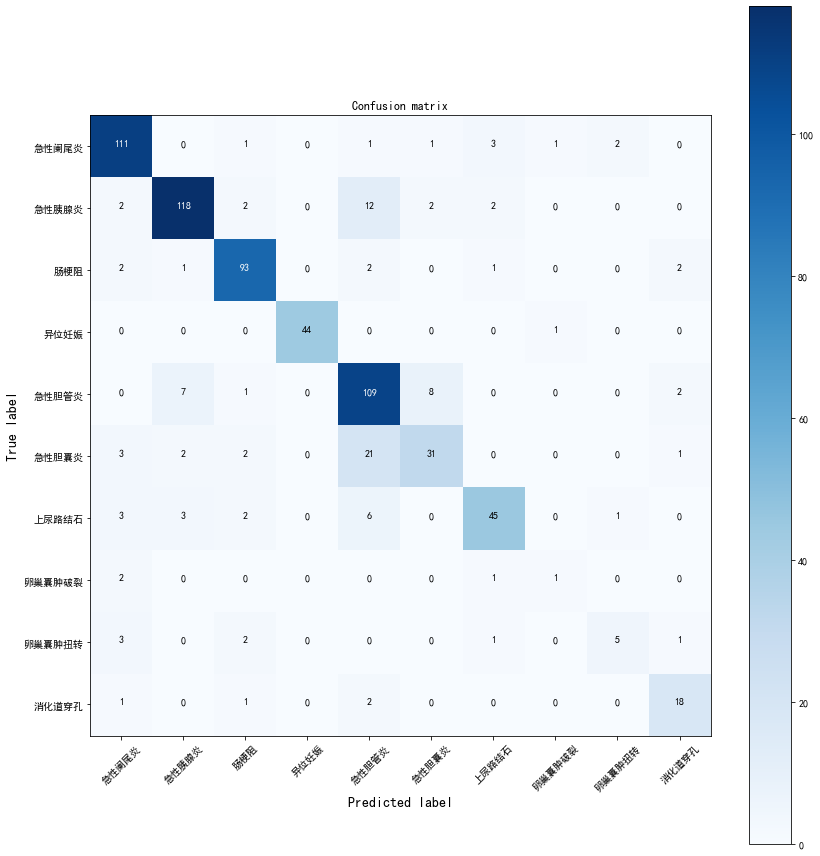

准确率: 83.45%


In [12]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_4.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_5.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
    
# 创建分类器
# model = svm.SVC()
model = GradientBoostingClassifier(max_features=90, max_depth=40, min_samples_split=8, min_samples_leaf=3,
                                    n_estimators=1200, learning_rate=0.05, subsample=0.95)

train_and_save(model, X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


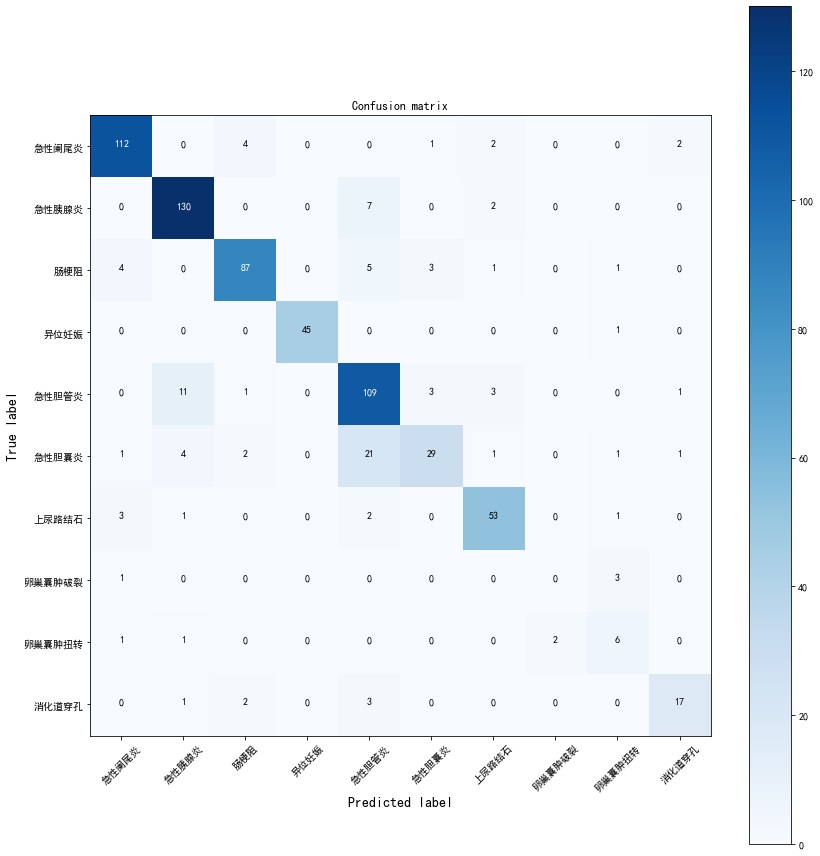

准确率: 84.97%


In [13]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_4.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


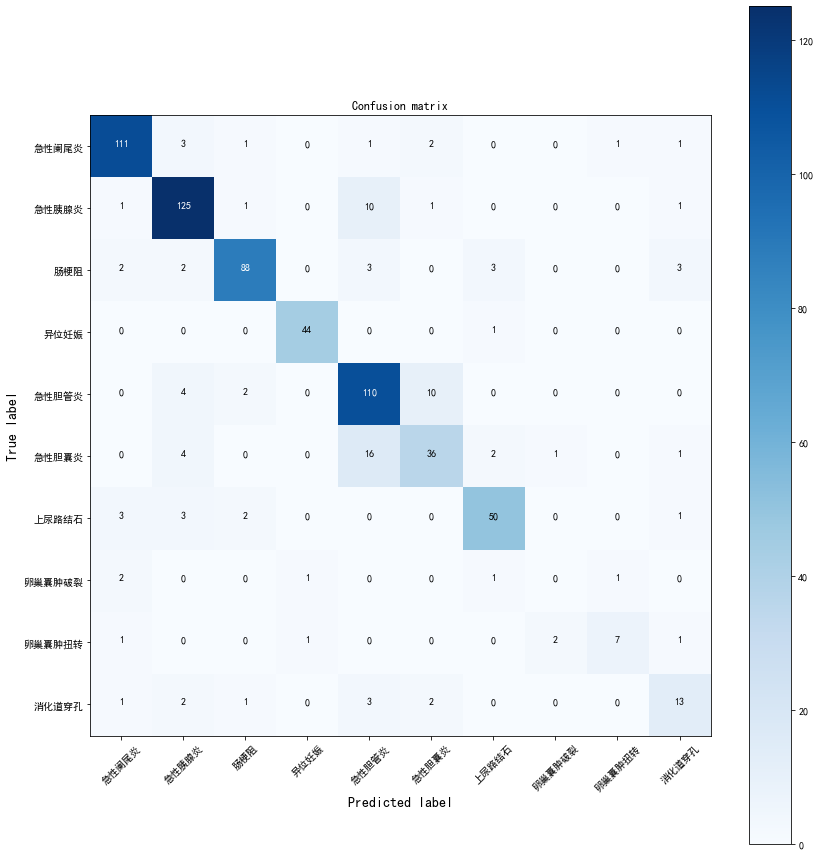

准确率: 84.76%


In [14]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_3.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


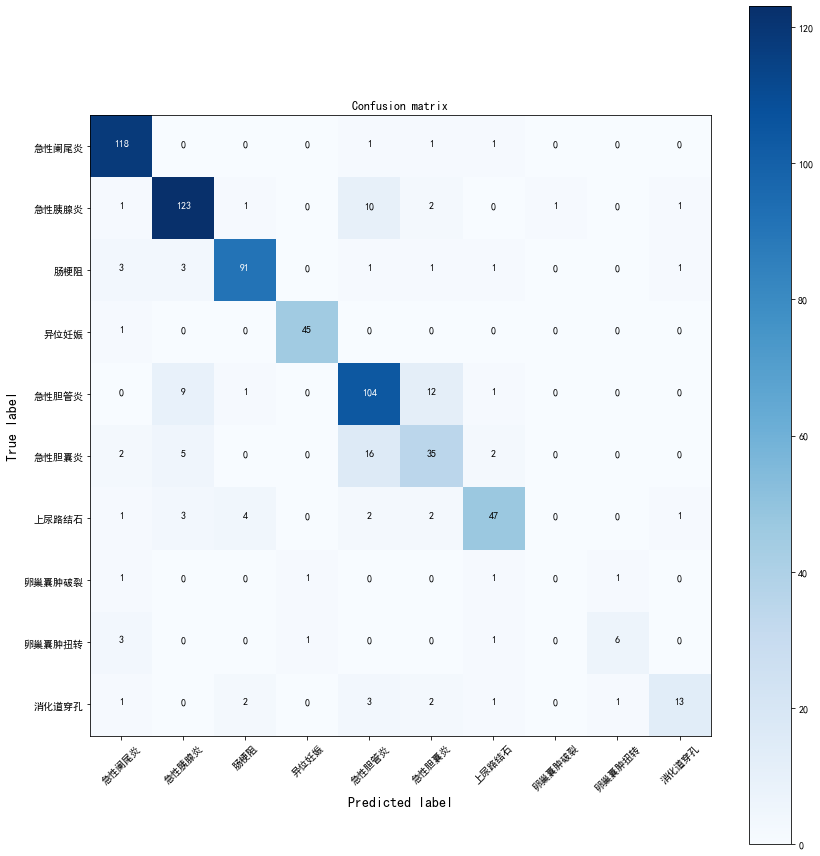

准确率: 84.10%


In [15]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_1.txt', r'data/疾病诊断拟合_全特征_3.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_2.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

6


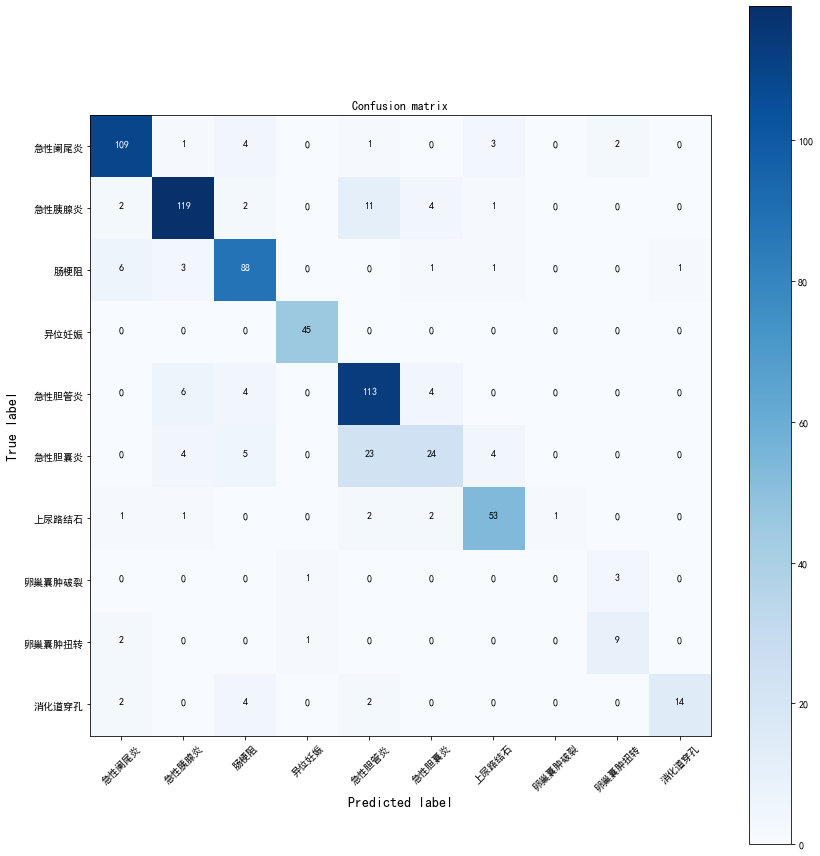

准确率: 83.31%


In [19]:
X_train, y_train, ids_train = load_data_arr([r'data/疾病诊断拟合_全特征_3.txt', r'data/疾病诊断拟合_全特征_2.txt', 
                           r'data/疾病诊断拟合_全特征_4.txt', r'data/疾病诊断拟合_全特征_5.txt'],
                          num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)
X_val, y_val, ids_val = load_data(r'data/疾病诊断拟合_全特征_1.txt', 
                            num_fields=171, separator='	', skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=170)

scaler, model = train_and_save(X_train, y_train, X_val, y_val, ids_val, 'gbdt_全量特征')

### 临床数据

6
0, total num: 602, train num: 482
2, total num: 505, train num: 404
1, total num: 695, train num: 556
4, total num: 637, train num: 510
6, total num: 299, train num: 239
5, total num: 300, train num: 240
8, total num: 58, train num: 46
3, total num: 227, train num: 182
9, total num: 112, train num: 90
7, total num: 21, train num: 17


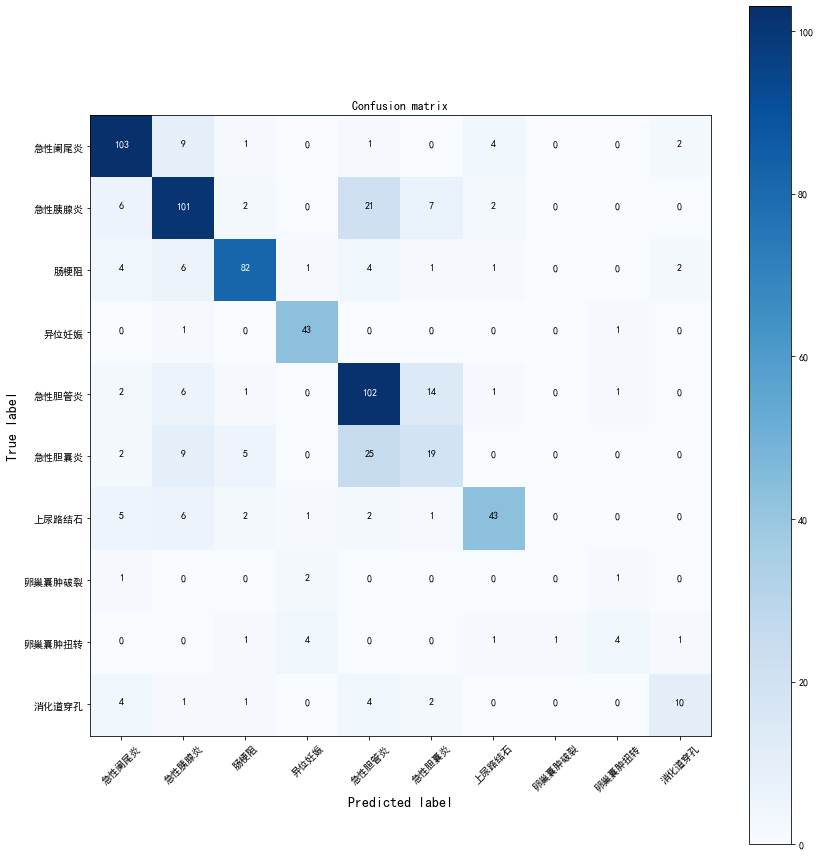

准确率: 73.48%


(StandardScaler(),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=40, max_features=90,
                            min_samples_leaf=3, min_samples_split=8,
                            n_estimators=1200, subsample=0.95))

In [6]:
train_X, train_y, val_X, val_y, val_id = load_data(r'data/疾病诊断拟合_临床.txt', num_fields=121, separator='	',
    skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=120)

train_and_save(train_X, train_y, val_X, val_y, val_id, 'gbdt_临床特征')

### 临床 + 实验室

6
0, total num: 602, train num: 482
6, total num: 299, train num: 239
3, total num: 227, train num: 182
9, total num: 112, train num: 90
2, total num: 505, train num: 404
8, total num: 58, train num: 46
4, total num: 637, train num: 510
5, total num: 300, train num: 240
1, total num: 695, train num: 556
7, total num: 21, train num: 17


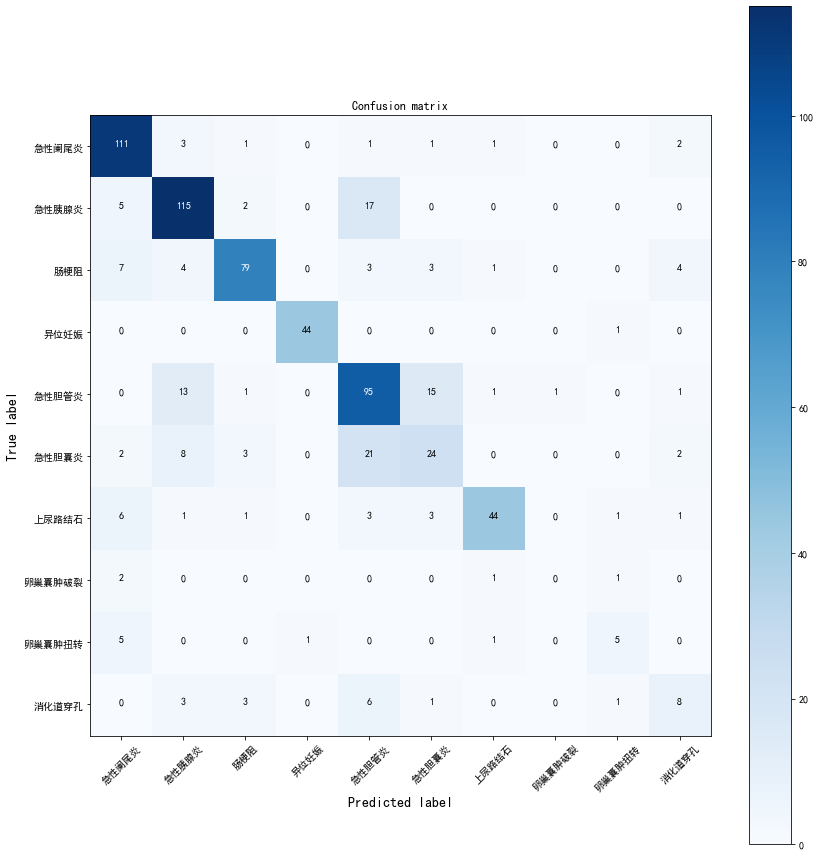

准确率: 76.09%


(StandardScaler(),
 GradientBoostingClassifier(learning_rate=0.05, max_depth=40, max_features=90,
                            min_samples_leaf=3, min_samples_split=8,
                            n_estimators=1200, subsample=0.95))

In [7]:
train_X, train_y, val_X, val_y, val_id = load_data(r'data/疾病诊断拟合_临床+实验室.txt', num_fields=139, separator='	',
        skip_title=True, cls_col=2, start_feature_col=3, end_feature_col=138)

train_and_save(train_X, train_y, val_X, val_y, val_id, 'gbdt_临床实验室')